# APPLIED DEEP LEARNING FINAL PROJECT
## Machine Learnig Solution
### Sandra Marcela Meneses - Diego Fernando López Castillo

Classify a movie genre based on its plot and its poster.

In this dataset we have a multilabel classification problem, where we need to predict the genre (a movie can be of many genres) from its poster.

We have two different datasets- one being the full dataset of movie information from the CSV file (Training and test), and the other being the images of the posters.

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,VotingClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

# Read Data

Load Training and Testing data

In [2]:
path = ''

In [3]:
dataTraining = pd.read_csv(os.path.join(path, 'data','dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path,'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [4]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Read gray Images

We are going to use the gray images to make the predictions.

In [6]:
image = io.imread(os.path.join(path, 'images_resize_gray', str(dataTraining.index[0]) + '_resize_gray.jpeg'))

In [7]:
image

array([[ 3,  3,  3, ..., 57, 55, 51],
       [ 3,  3,  3, ..., 99, 98, 95],
       [ 3,  3,  3, ..., 97, 96, 94],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

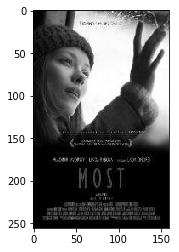

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

#### Read all images

Import training and testing images, into images_training array and images_testing array respectively.

In [9]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [00:05<00:00, 1410.71it/s]


In [10]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [11]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:02<00:00, 1459.77it/s]


((3383, 40960), 3383)

It will be possible to find more than one genre per movie, however, we find first how many genres we have in the datasets, and it is 24, so it will be a multiclassification model with 24 categories.

In [12]:
genrelist = []
length = len(dataTraining)
for n in range(0,length):
    genres = str(dataTraining.iloc[n]["genres"])
    genres = genres.replace('[','')
    genres = genres.replace(']','')
    genres = genres.replace('\'','')
    genres = genres.replace(' ','')
    genres = genres.split(",")
    genrelist.extend(genres) 
genrelist

['Short',
 'Drama',
 'Comedy',
 'Crime',
 'Horror',
 'Drama',
 'Film-Noir',
 'Thriller',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Drama',
 'Western',
 'Horror',
 'Thriller',
 'Drama',
 'Family',
 'Comedy',
 'Drama',
 'Fantasy',
 'Romance',
 'Comedy',
 'Sport',
 'Comedy',
 'Comedy',
 'Drama',
 'Thriller',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Western',
 'Comedy',
 'Romance',
 'Crime',
 'Drama',
 'Thriller',
 'Action',
 'Drama',
 'Thriller',
 'Drama',
 'Thriller',
 'Adventure',
 'Crime',
 'Mystery',
 'Romance',
 'Action',
 'Horror',
 'Sci-Fi',
 'Documentary',
 'History',
 'Music',
 'Drama',
 'Family',
 'Comedy',
 'Comedy',
 'Romance',
 'Documentary',
 'Biography',
 'History',
 'Horror',
 'Sci-Fi',
 'Thriller',
 'Comedy',
 'Drama',
 'Comedy',
 'Horror',
 'Sci-Fi',
 'Sport',
 'Action',
 'Adventure',
 'Drama',
 'Thriller',
 'Drama',
 'Mystery',
 'Sci-Fi',
 'Horror',
 'Thriller',
 'Adventure',
 'Comedy',
 'Family',
 'Comedy',
 'Action',
 'Drama',
 'Family',
 'Sport',
 'Drama',


In [13]:
unique_genres = list(set(genrelist))
print("Total Number of Genres is: " + str(len(unique_genres)))

Total Number of Genres is: 24


A bar chart is made by categories of movies.

Horror 954
Short 92
Animation 260
Adventure 1024
Drama 3965
Action 1303
Musical 271
Family 682
Biography 373
Western 237
Film-Noir 168
Thriller 2024
Sport 261
Romance 1892
Documentary 419
Sci-Fi 723
Crime 1447
Mystery 759
Music 341
War 348
Comedy 3046
History 273
Fantasy 707
News 7


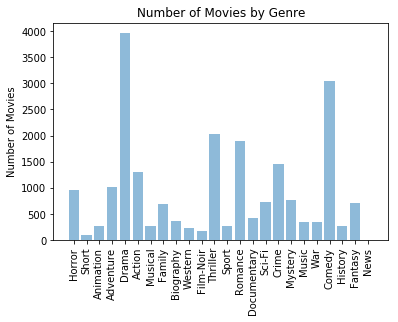

In [14]:
#Print amount of movies with specific genre
countlist = []
k=0
for genre in unique_genres:
    ct = genrelist.count(genre)
    countlist.append(ct)
    print(genre + " " + str(ct))

#Create Bar Graph of values
y_pos = np.arange(len(unique_genres))
plt.bar(y_pos,countlist,align='center',alpha=0.5)
plt.xticks(y_pos,unique_genres,rotation='vertical')
plt.ylabel("Number of Movies")
plt.title("Number of Movies by Genre")
plt.show()

It is analyzed graphically if there are very visible differences between the ratings of the movies

In [17]:
avglist = []
for genre in unique_genres:
    movies = dataTraining[dataTraining["genres"].str.contains(genre,na=False)]
    avg = movies["rating"].mean()
    avglist.append(avg)
    print(genre + " {0:.1f}".format(avg))

Horror 5.6
Short 7.3
Animation 6.7
Adventure 6.3
Drama 6.7
Action 6.0
Musical 6.7
Family 6.3
Biography 7.1
Western 6.9
Film-Noir 7.3
Thriller 6.2
Sport 6.5
Romance 6.5
Documentary 7.3
Sci-Fi 5.9
Crime 6.5
Mystery 6.4
Music 6.7
War 7.0
Comedy 6.2
History 7.0
Fantasy 6.2
News 7.5


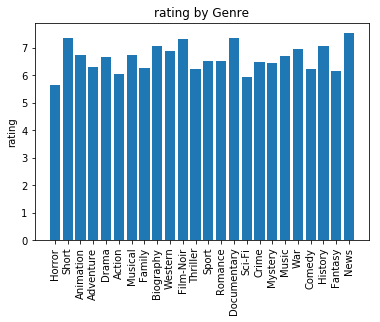

In [18]:
plt.bar(y_pos,avglist)
plt.xticks(y_pos,unique_genres,rotation='vertical')
plt.ylabel("rating")
plt.title("rating by Genre")
plt.show()